**This notebook shows how to write a CNN in PyTorch for MNIST dataset.**

In [1]:
# Import Dependencies
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set Seed for reporoducability
torch.manual_seed(100)

In [3]:
# Load Dataset
# root: directory for downloading the data or to look for data
# train: True during training
# transform: Converts a PIL.Image or numpy.ndarray to torch.FloatTensor of shape (C x H x W) 
#            and normalize it in the range [0.0, 1.0].
# download: True, if you want to download the data
training_Data = MNIST(
                root = "./dataset/",
                train = True,
                transform = transforms.ToTensor(),
                download = False)

In [4]:
print("Size of Training Images: ", training_Data.train_data.size())
print("Size of Training Labels: ", training_Data.train_labels.size())

Size of Training Images:  torch.Size([60000, 28, 28])
Size of Training Labels:  torch.Size([60000])


Text(0.5, 1.0, 'True Label: tensor(5)')

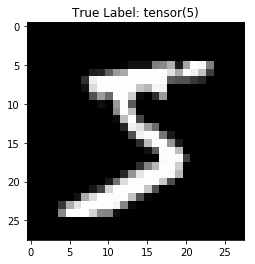

In [5]:
# Plot Sample data
img = training_Data.train_data[0].numpy()
label = training_Data.train_labels[0]

plt.imshow(img, cmap='gray')
plt.title("True Label: "+ str(label))

In [6]:
# Define Hyperparameters

# Epochs
epochs = 2

# Batch size
batchSize = 50

# Learning Rate
lr = 0.001

In [7]:
# Data Loader for Batching the Training Data
train_data_loader = Data.DataLoader(
              dataset = training_Data,
              batch_size = batchSize,
              shuffle = True,
              num_workers = 5)

In [8]:
# Load Test Data
# Convert Test Data into Variable
test_data = MNIST(root='./dataset/', train=False)

# Test Features
X_test = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(torch.FloatTensor)[:2000]/255.

# Test Labels
y_test = test_data.test_labels[:2000]

X_test.shape, y_test.shape

(torch.Size([2000, 1, 28, 28]), torch.Size([2000]))

### Define CNN Architecture

In [9]:
# CNN Model Function
class CNNModel(nn.Module):
    
    # Initialize Values
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define 1st Convolutional Layer
        
        # Input Shape: (1,28,28)
        # in_channel: Number of Inputs
        # out_channel: number of filters
        # kernel_stride: kernel/filter size
        # stride: filter movement/step
        # padding: pad image with 0's for equal width and height after this layer or not
        self.conv_1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2), # Output Shape: [16, 28, 28]
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size=2))  # Output Shape: [16, 14, 14]
        
        # Define 2nd Convolutional Layer
        
        # Input Shape: [16, 14, 14]
        # in_channel: Number of Inputs
        # out_channel: number of filters
        # kernel_stride: kernel/filter size
        # stride: filter movement/step
        # padding: pad image with 0's for equal width and height after this layer or not
        self.conv_2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2), # Output Shape: [32,14, 14]
                                   nn.ReLU(), 
                                   nn.MaxPool2d(kernel_size=2)) # Output Shape: [32,7,7]
        
        # Output Layer
        # 10 classes
        self.out = nn.Linear(32*7*7, 10)
        
    # Forward Pass
    def forward(self, x):
        # Conv Layer 1
        x = self.conv_1(x)
        # Conv Layer 2
        x = self.conv_2(x)
        # Flatten the Output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        # Output Layer
        output = self.out(x)
        return output, x

In [10]:
# Initialize Model
cnn = CNNModel()
print(cnn)

CNNModel(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [11]:
cnn.parameters

<bound method Module.parameters of CNNModel(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)>

In [12]:
# Define Optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr= lr)

In [13]:
# Loss Criteria
criteria = nn.CrossEntropyLoss()

In [14]:
# Plot Data with Labels
def plot_with_labels(lowDimensionWeights, labels):
    plt.figure(figsize = (20,6))
    plt.cla()
    X, Y = lowDimensionWeights[:, 0], lowDimensionWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize Last Layer')
    plt.pause(0.01)

In [15]:
plt.ion()

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 2.31146502494812 | Test Accuracy: 0.1395


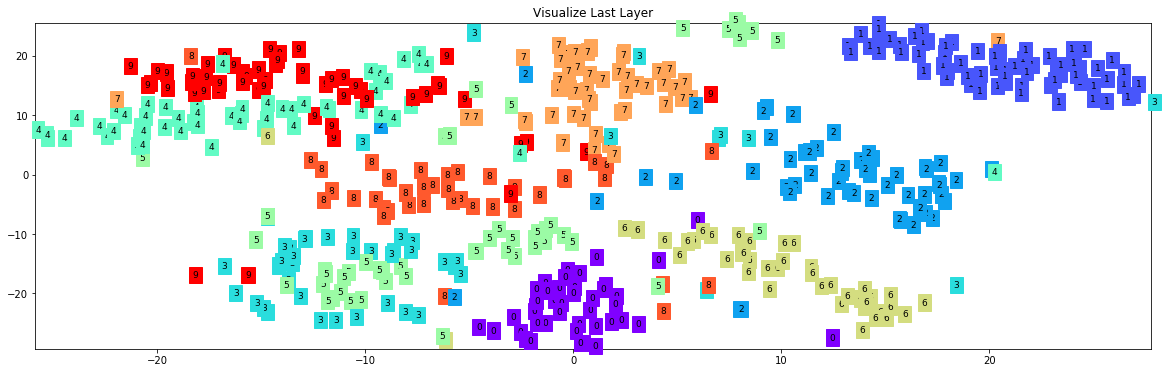

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.22367531061172485 | Test Accuracy: 0.888


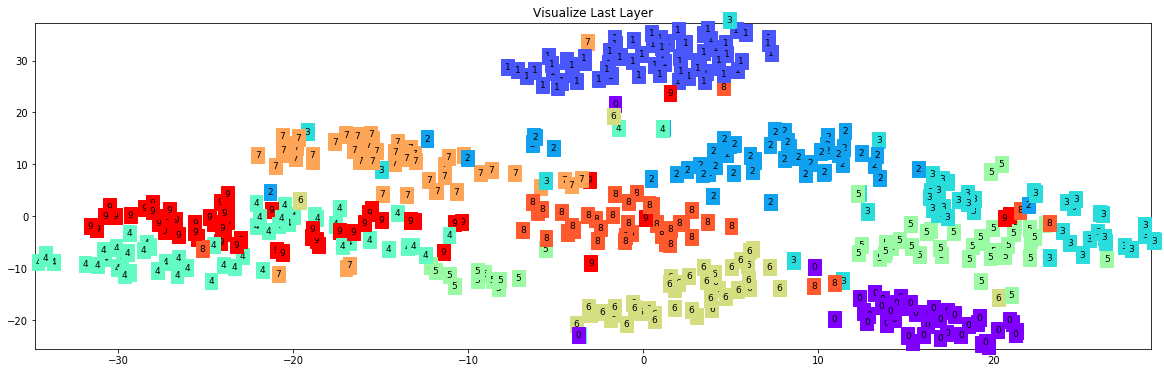

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.12676739692687988 | Test Accuracy: 0.937


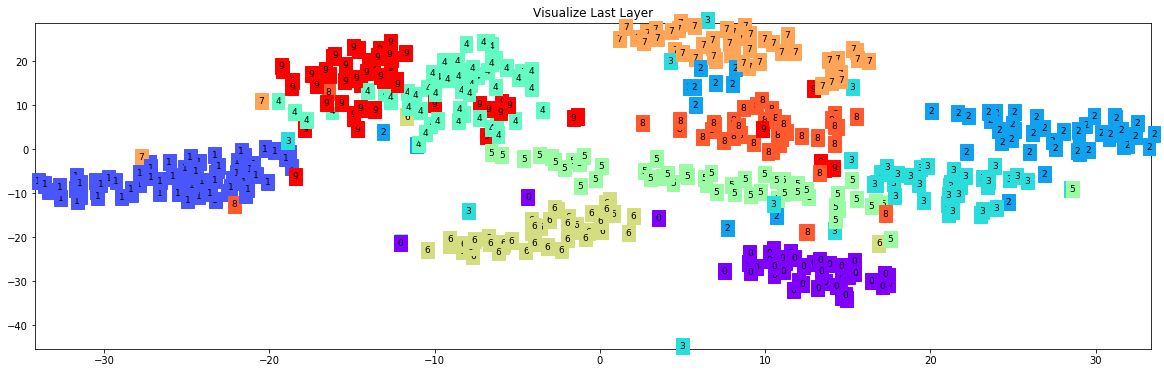

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.1478148251771927 | Test Accuracy: 0.948


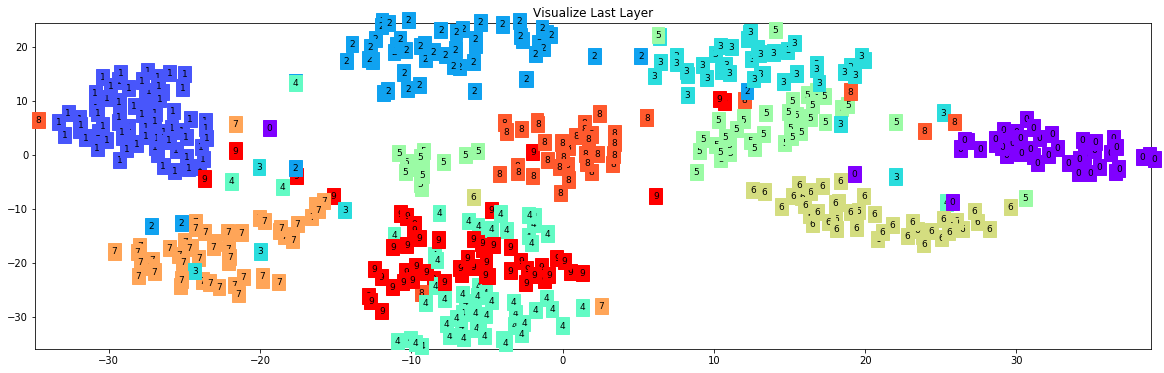

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.044247303158044815 | Test Accuracy: 0.9575


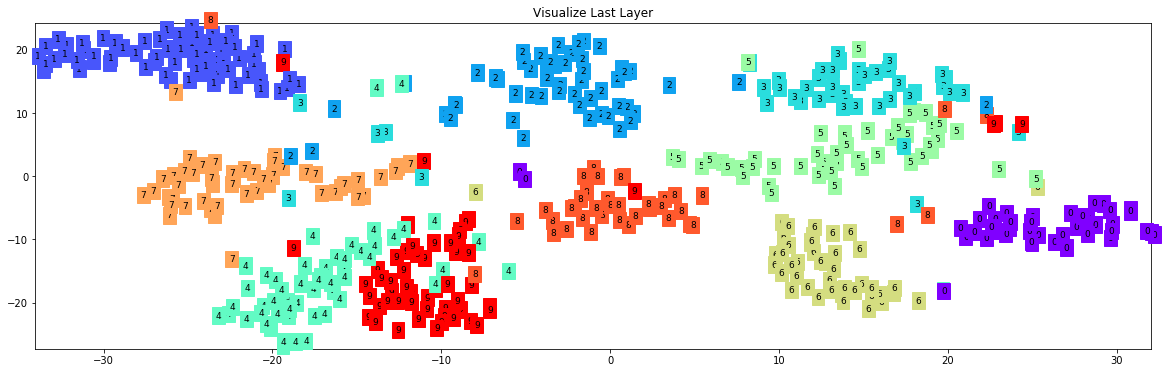

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.10475444793701172 | Test Accuracy: 0.958


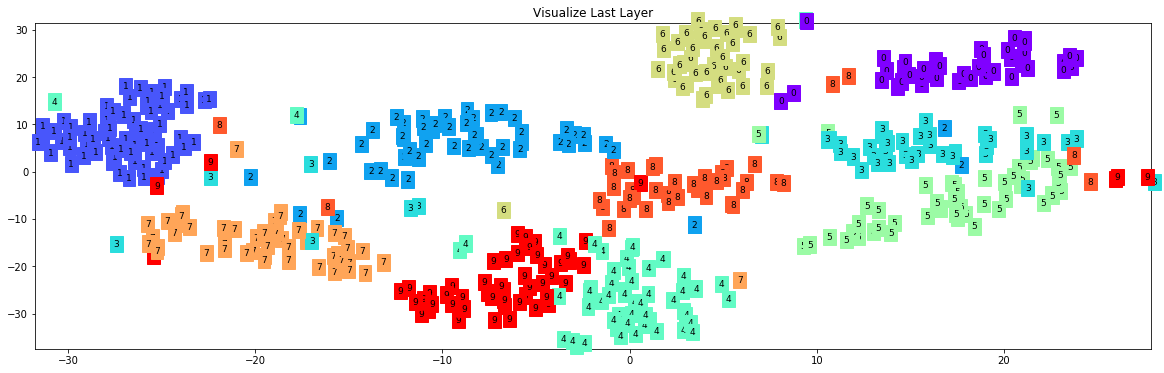

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.05777299031615257 | Test Accuracy: 0.9595


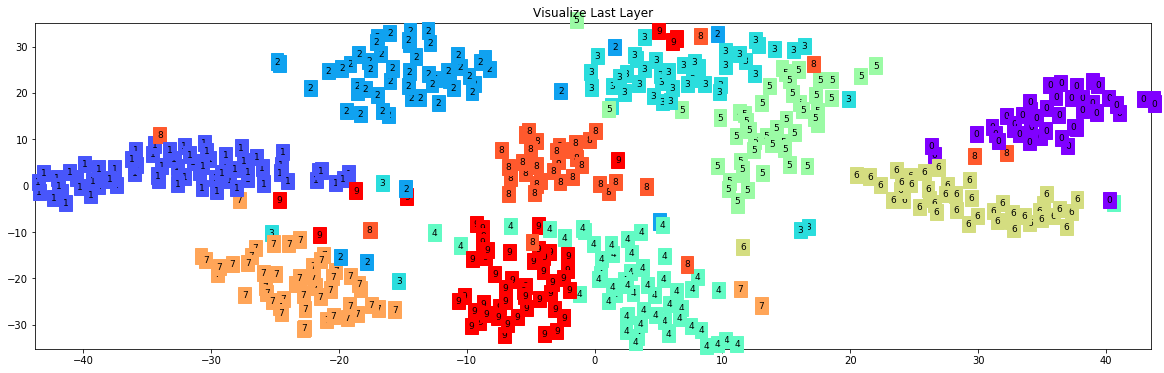

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.1239209845662117 | Test Accuracy: 0.9735


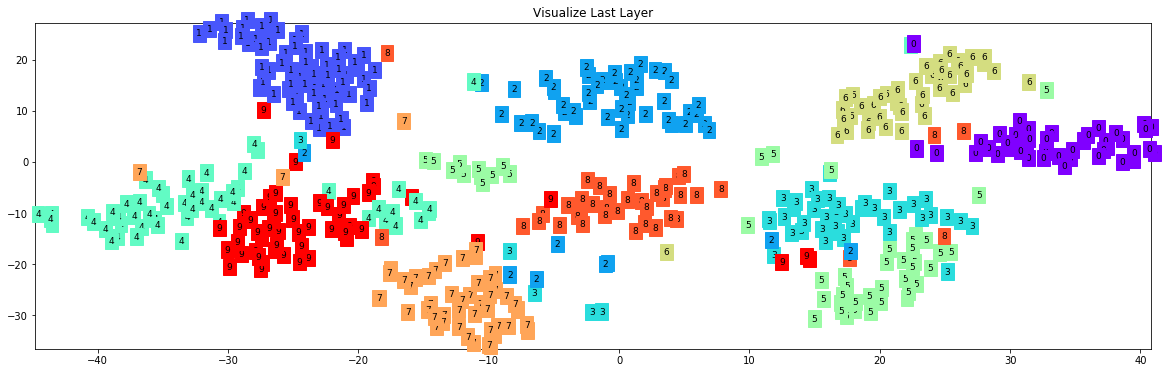

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.028231393545866013 | Test Accuracy: 0.9695


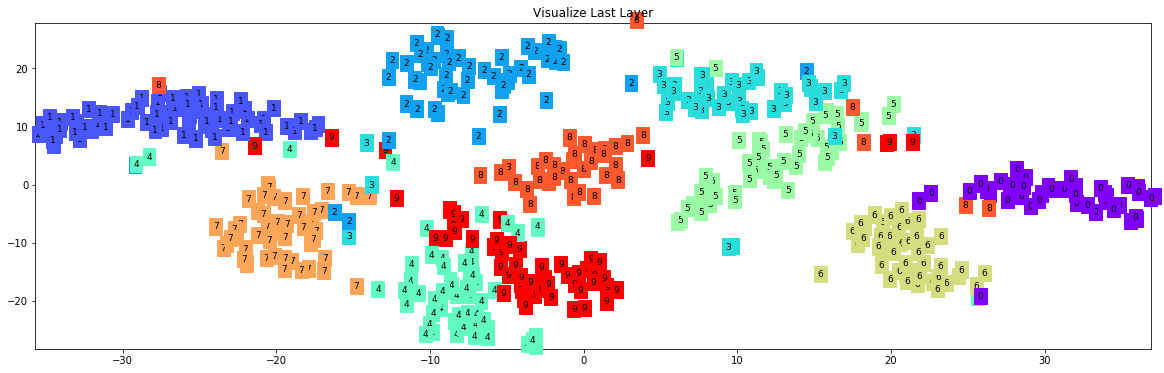

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.037265900522470474 | Test Accuracy: 0.9715


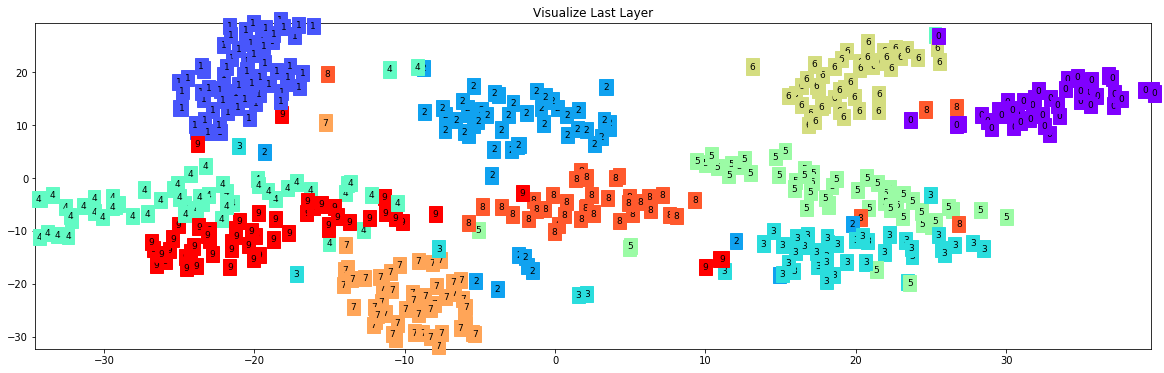

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.15952888131141663 | Test Accuracy: 0.9755


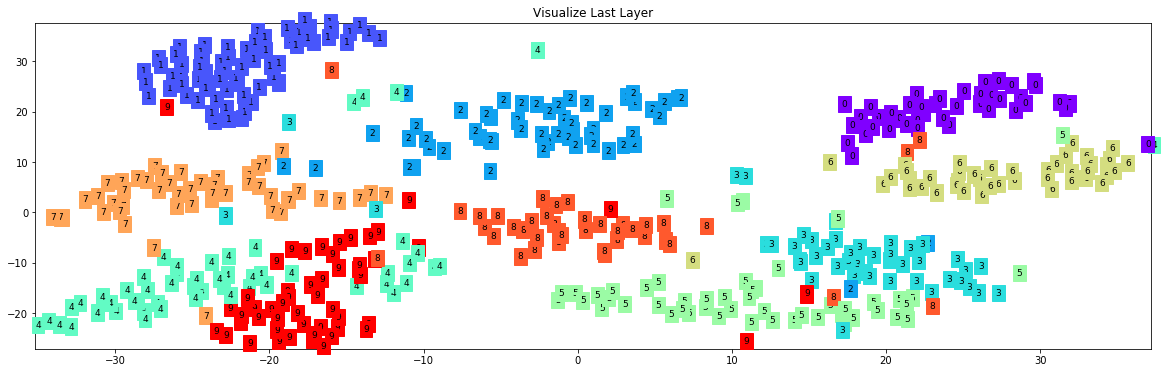

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 | Training Loss: 0.07448562979698181 | Test Accuracy: 0.9755


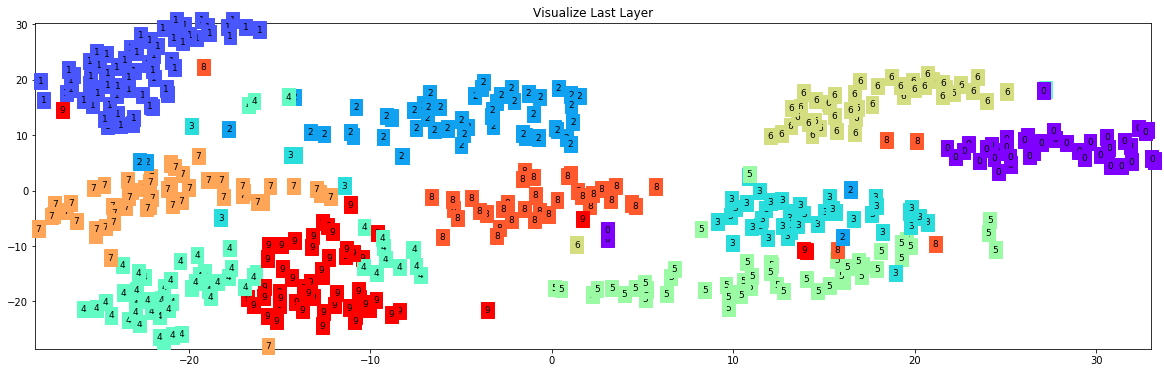

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.022038521245121956 | Test Accuracy: 0.973


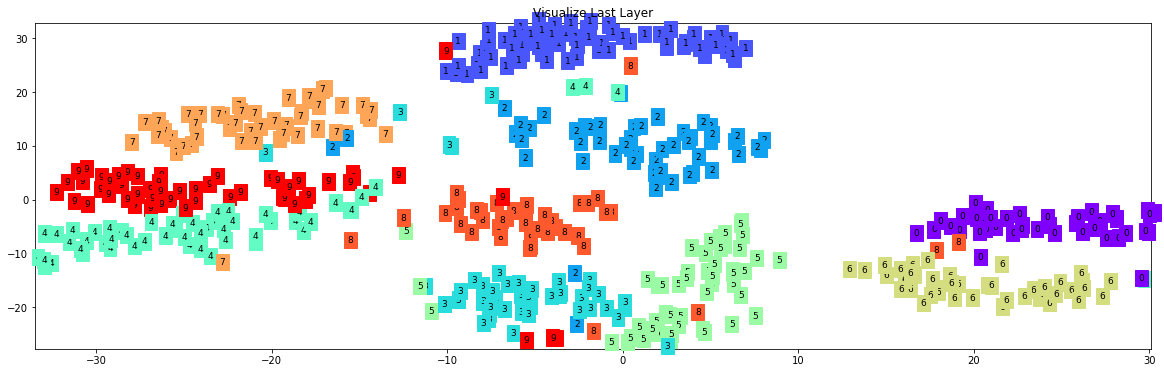

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.08956574648618698 | Test Accuracy: 0.976


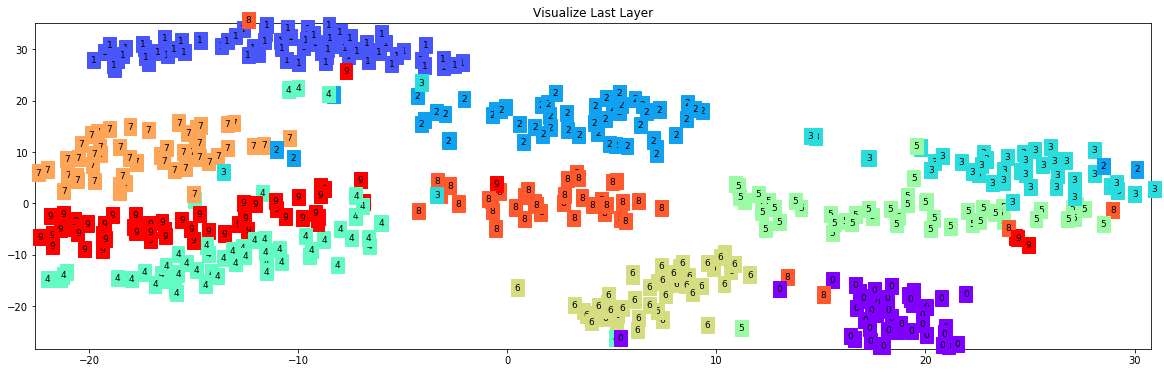

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.018571889027953148 | Test Accuracy: 0.9795


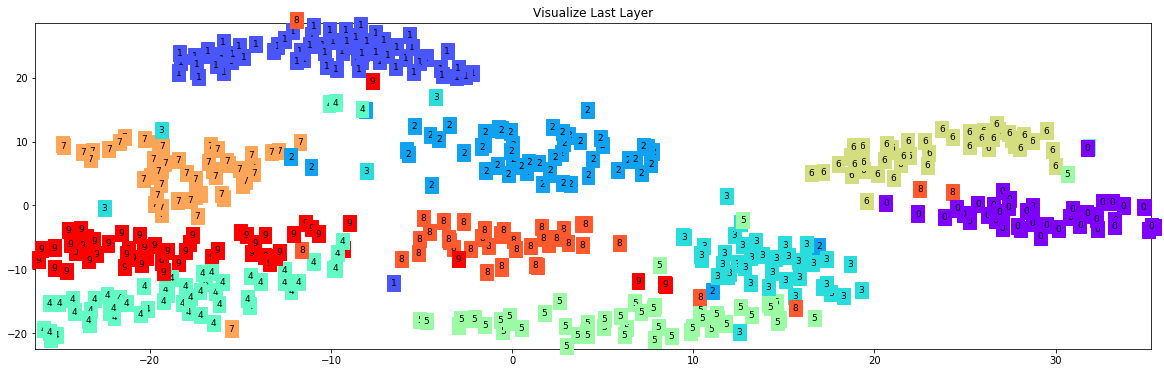

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.018731774762272835 | Test Accuracy: 0.974


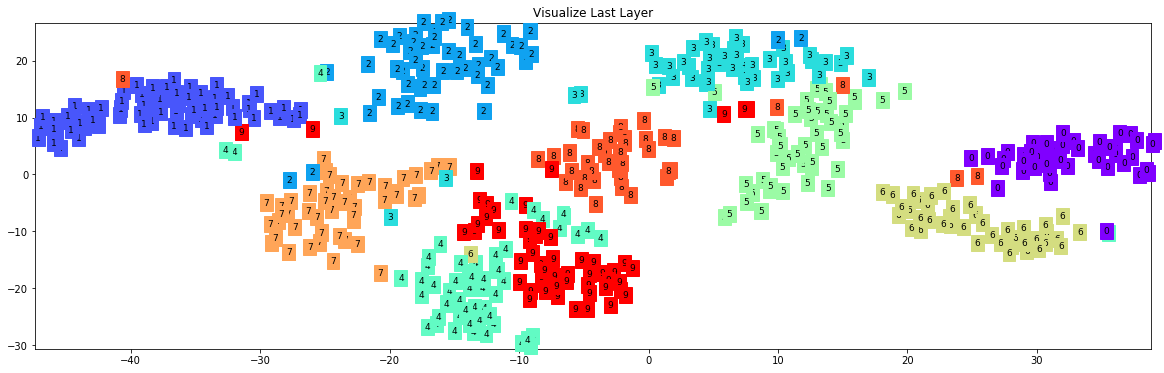

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.20140407979488373 | Test Accuracy: 0.9755


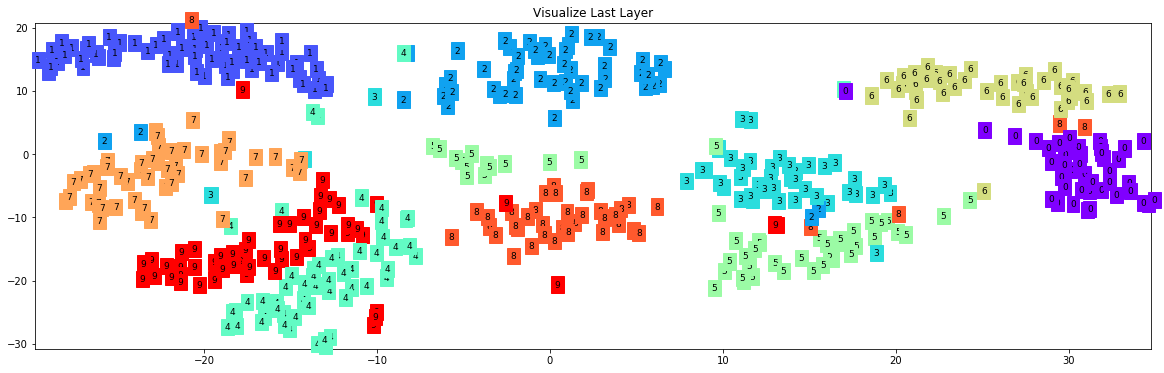

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.21553616225719452 | Test Accuracy: 0.9805


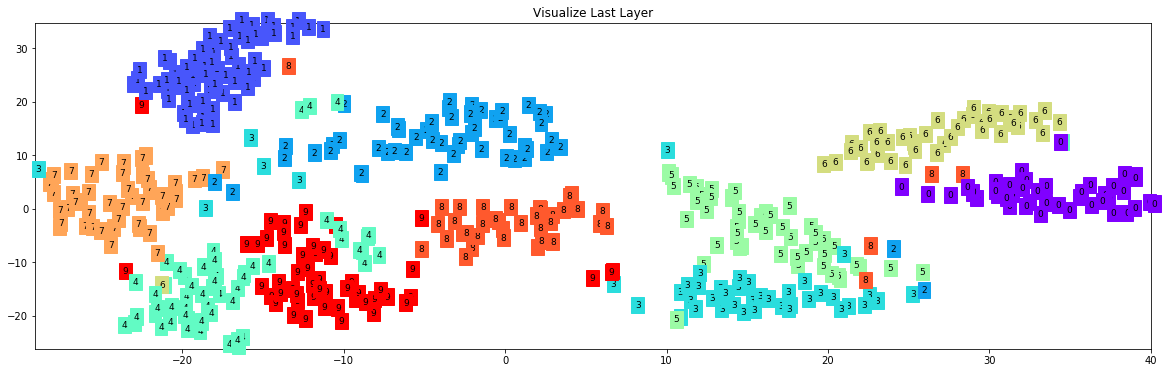

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.06421130895614624 | Test Accuracy: 0.9825


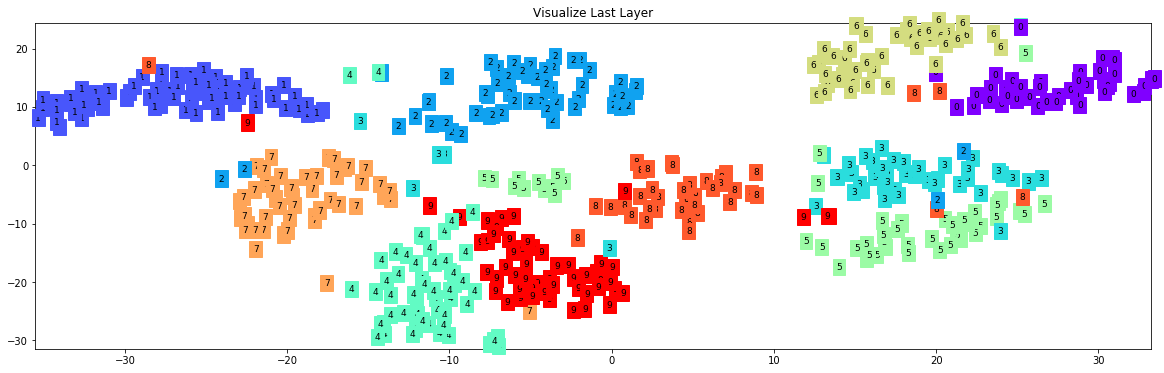

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.09561409801244736 | Test Accuracy: 0.9825


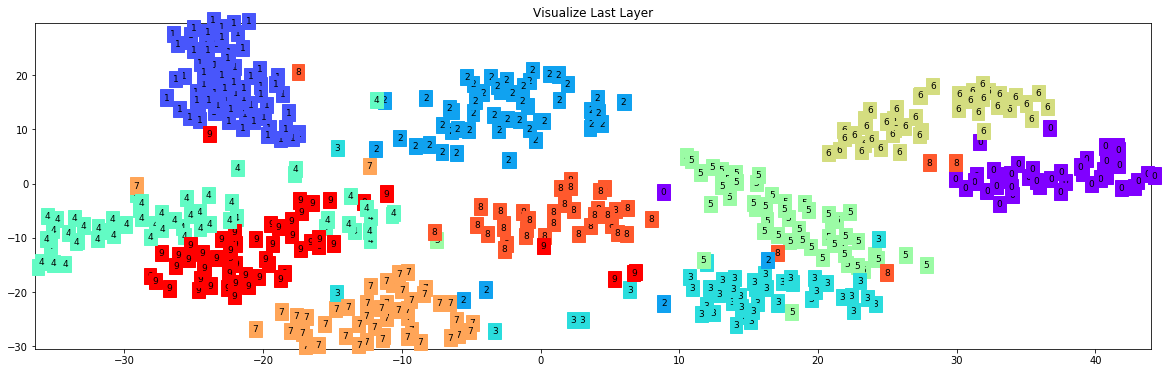

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.0011893940391018987 | Test Accuracy: 0.9825


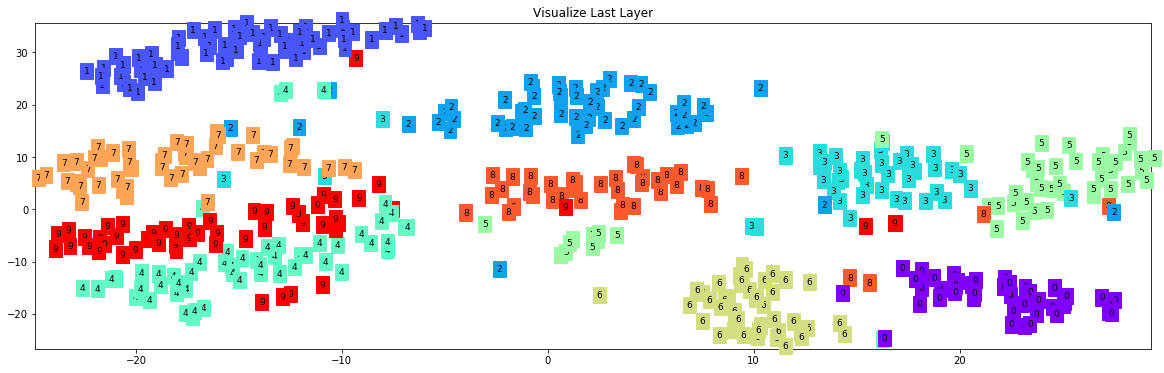

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.03828267753124237 | Test Accuracy: 0.9735


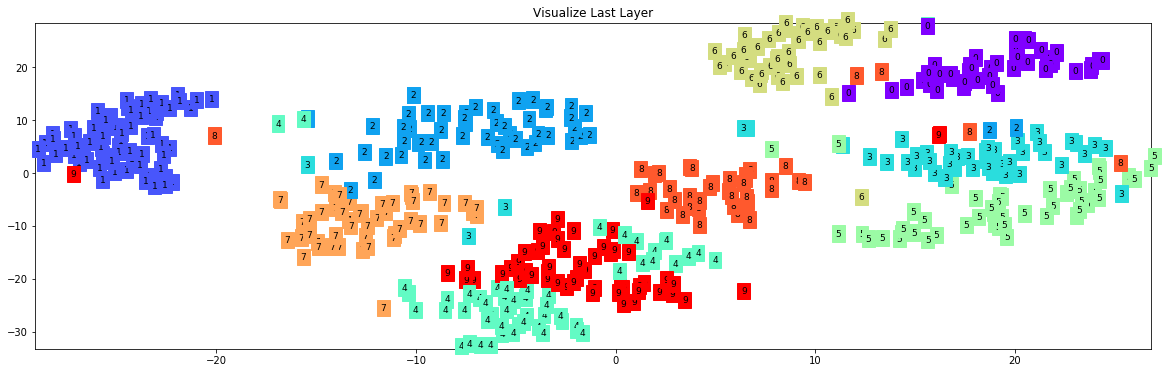

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.013712015002965927 | Test Accuracy: 0.979


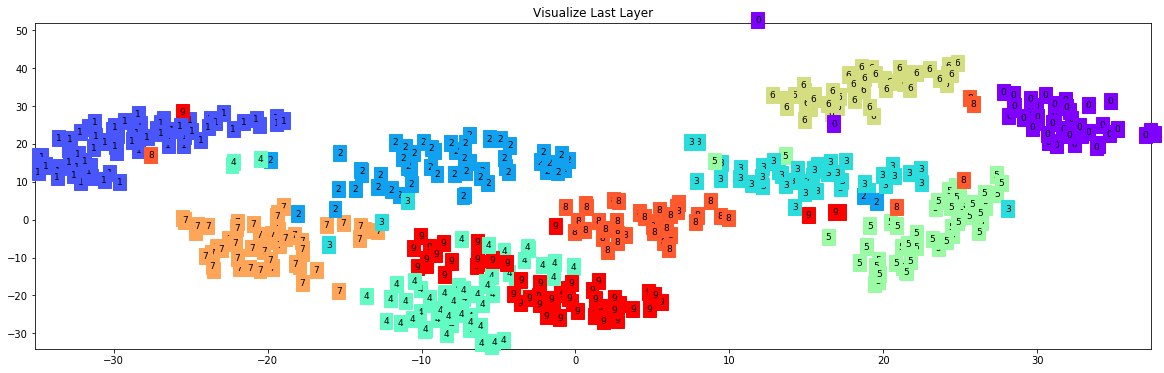

/Users/anujdutt/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 | Training Loss: 0.013619175180792809 | Test Accuracy: 0.98


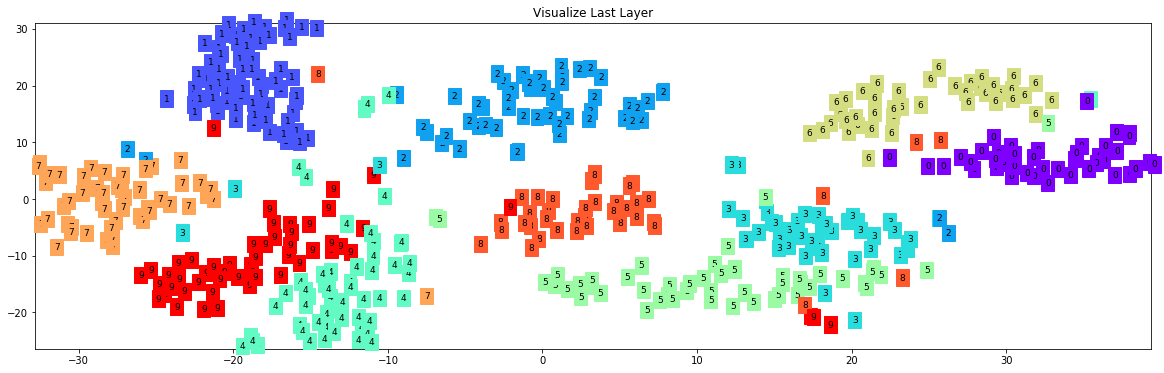

In [16]:
# Train the CNN Model
for epoch in range(epochs):
    
    # Load the Dataset in Batches
    for i, (X,y) in enumerate(train_data_loader):
        # Batch Features
        X_batch = Variable(X)
        
        # Batch Labels
        y_batch = Variable(y)
        
        # cnn's Output Prediction for Feature Input
        y_hat = cnn(X_batch)[0]
        
        # Calculate Loss
        loss = criteria(y_hat, y_batch)
        
        # Set Optimizer gradients to Zero
        optimizer.zero_grad()
        
        # Do loss Backpropagation
        loss.backward()
        
        # Apply new gradients
        optimizer.step()
        
        # Plot the Data after every Epoch to see how well is the model performing
        if i%100 == 0:
            # Get the predictions for Test data
            test_output, out_layer = cnn(X_test)
            
            # Predicted values for Test Data
            y_pred = torch.max(test_output,1)[1].data.squeeze()
            
            # Model Accuracy on Test Data
            accuracy = (y_pred == y_test).sum().item()/float(y_test.size(0))
            print("Epoch: {0} | Training Loss: {1} | Test Accuracy: {2}".format(epoch, loss.data[0],accuracy))
            
            # Plot the Data
            # Visualize the flattened layer
            tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
            
            # Get Low Dimension Embeddings
            low_dim_embeddings = tsne.fit_transform(out_layer.data.numpy()[:500, :])
            
            # Get Labels to plot from test labels
            labels = y_test.numpy()[:500]
            
            # Plot the Labels
            plot_with_labels(lowDimensionWeights=low_dim_embeddings, labels=labels)

plt.ioff()